In [17]:
import numpy as np
from large_gcs.geometry.polyhedron import Polyhedron
from large_gcs.geometry.ellipsoid import Ellipsoid
from large_gcs.geometry.point import Point
from large_gcs.graph.graph import Graph, DefaultGraphCostsConstraints, Edge, Vertex
from pydrake.all import (RandomGenerator, Variables, MathematicalProgram, DecomposeAffineExpression)
import matplotlib.pyplot as plt
import matplotlib.patches as patches


# Defining Collision Free Polyhedron WRT Object Center
So in this first part of the notebook, let's go through step by step how to define all the positions the center of an object can be in, given an initial polyhedron that we don't want any part of the object to protrude from. Let's start by making sure we understand the halfspace equations that define a polyhedron {x| A x ≤ b}.

A:
 [[-0.         -1.        ]
 [ 1.         -0.        ]
 [-0.          1.        ]
 [-1.          0.        ]
 [-0.83205029  0.5547002 ]]
b:
 [ 0.    10.     8.     0.     1.109]


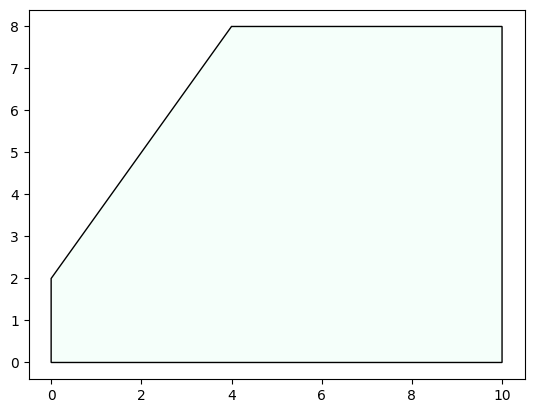

In [55]:
# Collision free set in world frame
S_coll_free_W= Polyhedron.from_vertices(([0,0],[10,0],[10,8],[4,8],[0,2]))
print("A:\n", S_coll_free_W.set.A())
print("b:\n", np.round(S_coll_free_W.set.b(),3))
S_coll_free_W.plot()

The first row of A and b correspond to the horizontal line at $y=0$, and specifies that all points must have $y\geq 0$. The normal of that halfspace is $[0,-1]$. The sloped line has a normal of $[-0.83,0.55]$ and corresponds to the inequality $-0.83x + 0.55y \leq 1.1$

We can get a bunch of randomly sampled points from within the polyhedron using the following helper function.

In [28]:
def get_samples_from_set(convex_set, n_samples=1000):
    samples = []
    generator = RandomGenerator(seed=1)
    samples.append(convex_set.set.UniformSample(generator))
    for i in range(n_samples-1):
        samples.append(convex_set.set.UniformSample(generator,previous_sample=samples[-1]))
    return samples

In [ ]:
S_coll_free_W= Polyhedron.from_vertices(([0,0],[10,-3],[13,5],[5,8]))
S_coll_free_W.plot()

Now I'm going to try making the set in the higher dimensional configuration space for the robot being to the right of the object and in contact, and every other face not being in contact.

[[ 0.         -1.        ]
 [ 1.          0.        ]
 [ 0.          1.        ]
 [-1.          0.        ]
 [-0.83205029  0.5547002 ]]
[-1.         11.          9.         -1.          0.83205029]


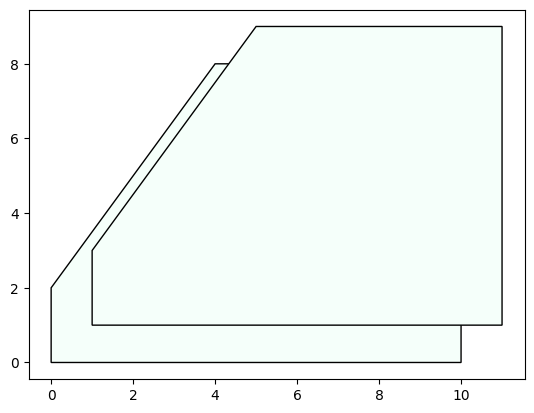

In [11]:
rob_radius = 1
A = S_coll_free_W.set.A()
b = S_coll_free_W.set.b()[:,np.newaxis]
prog = MathematicalProgram()
x = prog.NewContinuousVariables(2,"x")
p_ROB_boundary_W = x[:,np.newaxis] - rob_radius
exprs = A @ p_ROB_boundary_W - b
A_new = []
b_new = []
map_var_to_index = {v.get_id(): i for i, v in enumerate(x)}

for expr in exprs:
    coeffs, c0 = DecomposeAffineExpression(expr[0], map_var_to_index)
    A_new.append(coeffs)
    b_new.append(c0 * -1)
A_new = np.array(A_new)
b_new = np.array(b_new)
print(A_new)
print(b_new)
new_set = Polyhedron(A_new, b_new)
fig = plt.figure()
S_coll_free_W.plot()
new_set.plot()
plt.show()

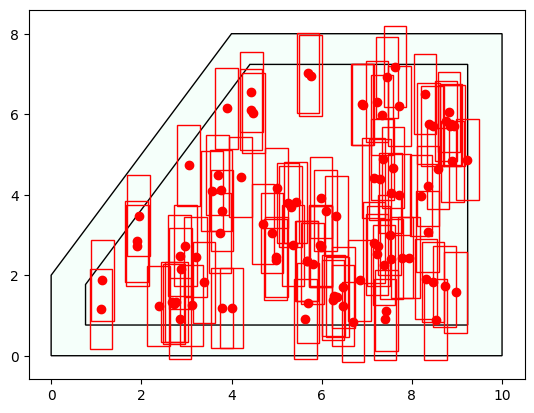

In [45]:
obj_radius = 1
obj_width = 0.5
obj_height = 2
rob_radius = 1

def plot_square(center, radius):
    bottom_left = np.array(center) - radius
    width = 2*radius
    square = patches.Rectangle(bottom_left, width, width, linewidth=1, edgecolor='r', facecolor='none')
    plt.gca().add_patch(square)

def plot_rectangle(center, width, height):
    bottom_left = np.array(center) - np.array([width/2, height/2])
    rect = patches.Rectangle(bottom_left, width, height, linewidth=1, edgecolor='r', facecolor='none')
    plt.gca().add_patch(rect)
    plt.scatter(center[0], center[1], c='r')

def plot_circle(center, radius):
    circle = patches.Circle(center, radius, linewidth=1, edgecolor='r', facecolor='none')
    plt.gca().add_patch(circle)

def proj_u_onto_v(u, v):
    u = np.array(u)
    v = np.array(v)
    return (np.dot(u,v)/np.linalg.norm(v))

A = S_coll_free_W.set.A()
b = S_coll_free_W.set.b() -  proj_u_onto_v([-obj_width/2, obj_height/2], [-0.83205029,0.5547002])
new_set = Polyhedron(A, b)
samples = get_samples_from_set(new_set, 100)
fig = plt.figure()
S_coll_free_W.plot()
new_set.plot()
for sample in samples:
    # plot_square(sample, obj_radius)
    # plot_circle(sample, obj_radius)
    plot_rectangle(sample, obj_width, obj_height)
# plt.grid()
plt.show()



In [47]:
proj_u_onto_v([-obj_width/2, obj_height/2], [-0.83205029,0.5547002])
proj_u_onto_v([-obj_width/2, obj_height/2], [1,0])

-0.25

In [ ]:
obj_radius = 1
rob_radius = 1
# Decision variables [p_ROB_W, p_OBJ_W, p_ROB_OBJ]
# p_ROB_OBJ = p_ROB_W - p_OBJ_W

def make_set(coll_free_polyhedron):
    A = coll_free_polyhedron.set.A()
    b = coll_free_polyhedron.set.b()[:, np.newaxis]
    prog = MathematicalProgram()

    x = prog.NewContinuousVariables(6, "x")
    p_ROB_W = x[0:2, np.newaxis] - rob_radius
    p_ROB_W_exprs = A @ p_ROB_W - b
    p_OBJ_W = x[2:4, np.newaxis] - obj_radius
    p_OBJ_W_exprs = A @ p_OBJ_W - b
    exprs = np.vstack((p_ROB_W_exprs, p_OBJ_W_exprs))
    print(exprs)

make_set(S_coll_free_W)
# # Collision free expressions:
# exprs = [
#     -(x[0]+rob_radius),
#     -(x[1]+rob_radius),
# ]
# map_var_to_index = {v.get_id(): i for i, v in enumerate(x)}
# coeffs, c0 = DecomposeAffineExpression(exprs[0], map_var_to_index)
# print(coeffs)
# print(c0)